<a href="https://colab.research.google.com/github/Evolved360/Neural-Inc/blob/main/Feature_engineering_and_featurization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install relevant packages
!pip install CBFV
!pip install matminer
!pip install scikit-learn==1.0.2
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Import all relevant libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold
import CBFV
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from CBFV.composition import generate_features as gf
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# Import extracted battery data
Li_data = pd.read_csv('Li_data.csv')
Ca_data = pd.read_csv('Ca_data.csv')
Mg_data = pd.read_csv('Mg_data.csv')
Cs_data = pd.read_csv('Cs_data.csv')
K_data = pd.read_csv('K_data.csv')
Na_data = pd.read_csv('Na_data.csv')
Al_data = pd.read_csv('Al_data.csv')
Rb_data = pd.read_csv('Rb_data.csv')
Y_data = pd.read_csv('Y_data.csv')
Zn_data = pd.read_csv('Zn_data.csv')

In [ ]:
# Combine the imported data
battery_data = pd.concat([Li_data, Ca_data, Mg_data, Cs_data, K_data, Na_data, Al_data, Rb_data, Y_data, Zn_data])
battery_data.reset_index(drop = True, inplace = True)
battery_data.to_csv('battery_data.csv', index=False)

# Display the data
battery_data.head()

,battery_type,battery_id,thermo_type,battery_formula,working_ion,num_steps,max_voltage_step,last_updated,framework,framework_formula,...,volume_charge,volume_discharge,band_gap_charge,band_gap_discharge,energy_above_hull_charge,energy_above_hull_discharge,ordering_charge,ordering_discharge,density_atomic_charge,density_atomic_discharge
0,NaN,mp-757871_Li,NaN,Li2-4CoNi3O8,Li,2,0.221134,2022-06-28 03:50:55.322,Co1 Ni3 O8,CoNi3O8,...,136.932319,138.120131,0.0000,0.0728,0.033696,0.005797,FM,FiM,9.780880,8.632508
1,NaN,mp-755220_Li,NaN,Li3-4CrNi3O8,Li,1,0.000000,2022-06-28 03:50:55.322,Cr1 Ni3 O8,CrNi3O8,...,141.035503,140.519241,0.0000,0.0000,0.089458,0.038080,FM,FiM,9.402367,8.782453
2,NaN,mp-762224_Li,NaN,Li0-4Cu3Sb(PO4)4,Li,1,0.000000,2022-06-28 03:50:55.322,Cu3 Sb1 P4 O16,Cu3Sb(PO4)4,...,288.123451,310.859846,0.0022,0.0000,0.069619,0.072188,FiM,FM,12.005144,11.102137
3,NaN,mp-759472_Li,NaN,Li1-2Cu(HO)4,Li,1,0.000000,2022-06-28 03:50:55.322,Cu1 H4 O4,Cu(HO)4,...,352.119752,343.634432,1.4109,0.0000,0.081335,0.079091,NM,FM,8.802994,7.809873
4,NaN,mp-772496_Li,NaN,Li0-4Mn3CuNi2(PO4)6,Li,1,0.000000,2022-06-28 03:50:55.322,Mn3 Cu1 Ni2 P6 O24,Mn3CuNi2(PO4)6,...,430.027099,460.683513,0.0000,0.0000,0.046100,0.083395,FM,FiM,11.945197,11.517088


In [ ]:
# Create a list of redundant columns
irrelevant_columns = ['battery_type', 'battery_id', 'thermo_type', 'last_updated', 'id_charge', 'id_discharge', 'host_structure', 'adj_pairs',
                     'material_ids', 'entries_composition_summary', 'electrode_object', 'fields_not_requested', 'elements', 'framework', 'warnings',
                     'formula_charge', 'formula_discharge', 'formula_anonymous', 'chemsys', 'battery_formula']


# Remove redundant columns
battery_data.drop(irrelevant_columns, axis=1, inplace=True)

# Display the cleaned data
battery_data.head()

,working_ion,num_steps,max_voltage_step,framework_formula,nelements,max_delta_volume,average_voltage,capacity_grav,capacity_vol,energy_grav,...,volume_charge,volume_discharge,band_gap_charge,band_gap_discharge,energy_above_hull_charge,energy_above_hull_discharge,ordering_charge,ordering_discharge,density_atomic_charge,density_atomic_discharge
0,Li,2,0.221134,CoNi3O8,3,0.008674,3.645088,137.171754,644.437651,500.003153,...,136.932319,138.120131,0.0000,0.0728,0.033696,0.005797,FM,FiM,9.780880,8.632508
1,Li,1,0.000000,CrNi3O8,3,0.003674,3.555958,69.825436,316.717528,248.296319,...,141.035503,140.519241,0.0000,0.0000,0.089458,0.038080,FM,FiM,9.402367,8.782453
2,Li,1,0.000000,Cu3Sb(PO4)4,4,0.078912,3.637514,148.887306,572.668449,541.579600,...,288.123451,310.859846,0.0022,0.0000,0.069619,0.072188,FiM,FM,12.005144,11.102137
3,Li,1,0.000000,Cu(HO)4,3,0.024693,2.901634,184.256618,518.049443,534.645191,...,352.119752,343.634432,1.4109,0.0000,0.081335,0.079091,NM,FM,8.802994,7.809873
4,Li,1,0.000000,Mn3CuNi2(PO4)6,5,0.071289,3.757691,113.645161,386.424999,427.043409,...,430.027099,460.683513,0.0000,0.0000,0.046100,0.083395,FM,FiM,11.945197,11.517088


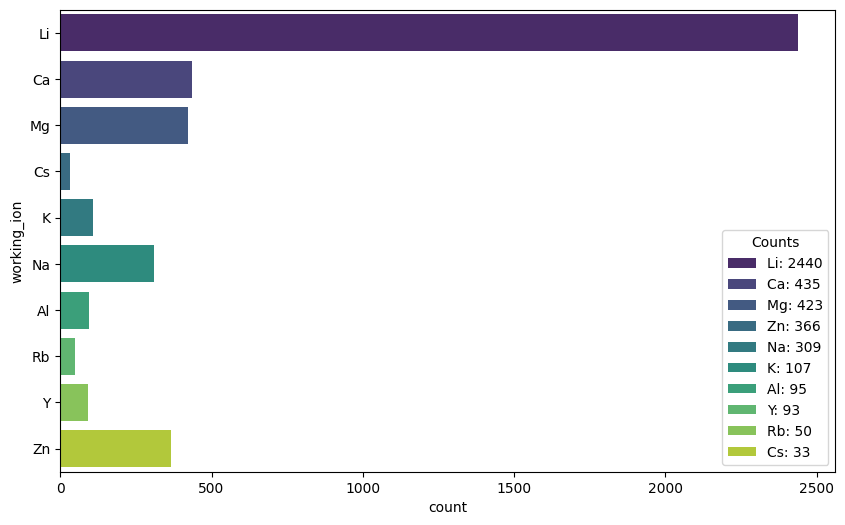

In [ ]:
#Create a bar chart to visualize the number of working ions for each electrode
plt.figure(figsize=(10, 6))
ax = sns.countplot(battery_data['working_ion'], palette='viridis')

# Get the unique categories and their counts
categories = battery_data['working_ion'].value_counts().index.tolist()
counts = battery_data['working_ion'].value_counts().tolist()

# Create custom legend
legend_labels = [f'{cat}: {count}' for cat, count in zip(categories, counts)]
ax.legend(handles=ax.patches, labels=legend_labels, title='Counts')

<Axes: >

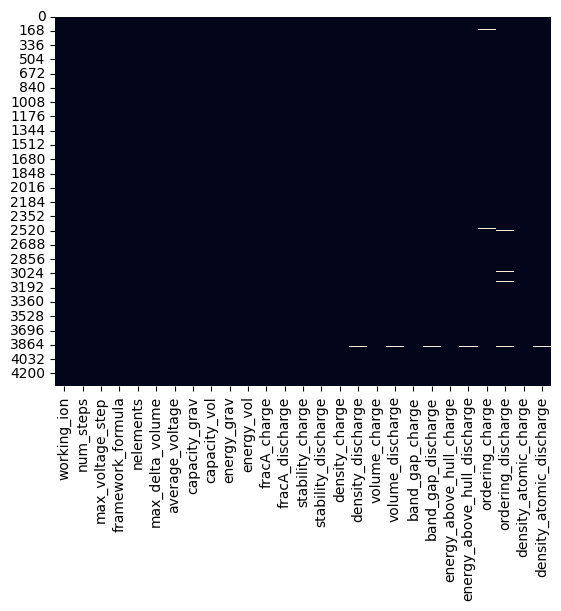

In [ ]:
# Display missing battery data
sns.heatmap(battery_data.isnull(), cbar=False)

<Axes: >

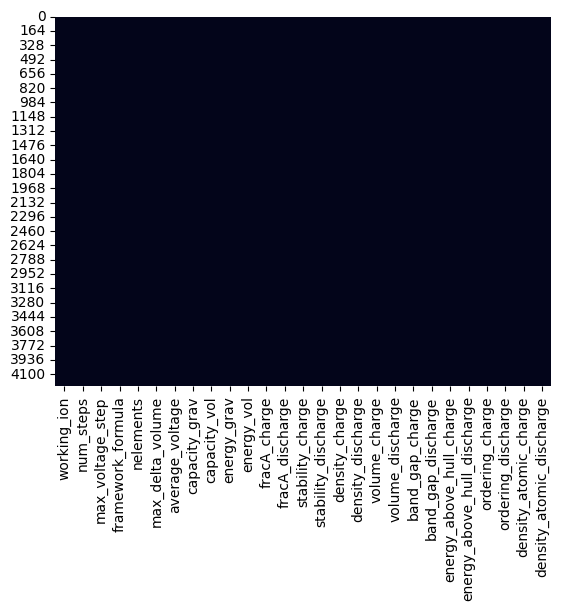

In [ ]:
# Remove missing data
battery_data.dropna(inplace=True)
battery_data.reset_index(drop = True, inplace = True)

# Display heatmap without missing data
sns.heatmap(battery_data.isnull(), cbar=False)

In [ ]:
# Display battery information with cleaned data
battery_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   working_ion                  4238 non-null   object 
 1   num_steps                    4238 non-null   int64  
 2   max_voltage_step             4238 non-null   float64
 3   framework_formula            4238 non-null   object 
 4   nelements                    4238 non-null   int64  
 5   max_delta_volume             4238 non-null   float64
 6   average_voltage              4238 non-null   float64
 7   capacity_grav                4238 non-null   float64
 8   capacity_vol                 4238 non-null   float64
 9   energy_grav                  4238 non-null   float64
 10  energy_vol                   4238 non-null   float64
 11  fracA_charge                 4238 non-null   float64
 12  fracA_discharge              4238 non-null   float64
 13  stability_charge  

# **FEATURIZATION**

In [ ]:
# Featurize categorical data with one-hot encoding
battery_data = pd.get_dummies(battery_data, columns=['working_ion'], prefix = ['working_ion'], dtype = float)
battery_data = pd.get_dummies(battery_data, columns=['ordering_charge'], prefix = ['ordering_charge'], dtype = float)
battery_data = pd.get_dummies(battery_data, columns=['ordering_discharge'], prefix = ['ordering_discharge'], dtype = float)

# Display featurized data
battery_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   num_steps                    4238 non-null   int64  
 1   max_voltage_step             4238 non-null   float64
 2   framework_formula            4238 non-null   object 
 3   nelements                    4238 non-null   int64  
 4   max_delta_volume             4238 non-null   float64
 5   average_voltage              4238 non-null   float64
 6   capacity_grav                4238 non-null   float64
 7   capacity_vol                 4238 non-null   float64
 8   energy_grav                  4238 non-null   float64
 9   energy_vol                   4238 non-null   float64
 10  fracA_charge                 4238 non-null   float64
 11  fracA_discharge              4238 non-null   float64
 12  stability_charge             4238 non-null   float64
 13  stability_discharg

# **COMPOSITION BASED FEATURE VECTORIZATION(CBFV)**

In [ ]:
# Create a dataframe of data to be featurized
sample_data = battery_data[['framework_formula','average_voltage' ]]

# View information of new dataframe
sample_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   framework_formula  4238 non-null   object 
 1   average_voltage    4238 non-null   float64
dtypes: float64(1), object(1)
memory usage: 66.3+ KB


In [ ]:
# Rename columns in dataframe
sample_data.rename(columns={'framework_formula': 'formula',
                            'average_voltage': 'target'}, inplace=True)

sample_data.head()

,formula,target
0,CoNi3O8,3.645088
1,CrNi3O8,3.555958
2,Cu3Sb(PO4)4,3.637514
3,Cu(HO)4,2.901634
4,Mn3CuNi2(PO4)6,3.757691


In [ ]:
# Save data to csv file
sample_data.to_csv('sample_data.csv', index=False)

In [ ]:
# Create a class to featurize framework formula to obtain physiochemical properties for electrodes
class Featurize():
    def __init__(self, data_path, scale=True, save=True):
        self.data_path = data_path
        self.scale = scale
        self.save = save
        self.get_xy()

    def get_xy(self):
        df = pd.read_csv(self.data_path)
        df.columns = ['formula', 'target']
        self.df = df
        X, y, formulae, skipped = gf(df, elem_prop='oliynyk')
        self.columns = X.columns
        self.X = X
        self.y = y
        if self.scale:
            self.scaler = StandardScaler()
            self.X = normalize(self.scaler.fit_transform(X))
        self.formula = formulae
        self.skipped = skipped


train_file = 'sample_data.csv'

# create a model (featurization of train data here)
feats = Featurize(train_file, scale=True, save=True)

Processing Input Data: 100%|██████████| 4238/4238 [00:00<00:00, 8251.65it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 4238/4238 [00:00<00:00, 4342.68it/s]


	Creating Pandas Objects...


In [ ]:
# Create a dataframe from featurized data
featurized_data = pd.DataFrame(feats.X, columns=feats.columns)
featurized_data.reset_index()
featurized_data.to_csv('cbfv_data.csv', index=False)

In [ ]:
battery_data = pd.concat([battery_data,featurized_data], axis = 1)
battery_data.drop(['framework_formula'], axis=1, inplace=True)


In [ ]:
feature_name_mapping = {
    'energy_grav': 'Gravimetric Energy',
    'capacity_grav': 'Gravimetric Capacity',
    'capacity_vol': 'Volumetric Capacity',
    'avg_Mendeleev_Number': 'Average Mendeleev Number',
    'energy_vol': 'Volumetric Energy',
    'range_metallic_valence': 'Range of Metallic Valence',
    'working_ion_Zn': 'Working Ion',
    'band_gap_charge': 'Charged Band Gap',
    'avg_Atomic_Radius': 'Average Atomic Radius',
    'stability_discharge': 'Discharge Stability'}

battery_data = battery_data.rename(columns=feature_name_mapping)

In [ ]:
X = battery_data.drop('average_voltage', axis=1)
y = battery_data['average_voltage']

# PRINCIPAL COMPONENT ANALYSIS(**PCA**)

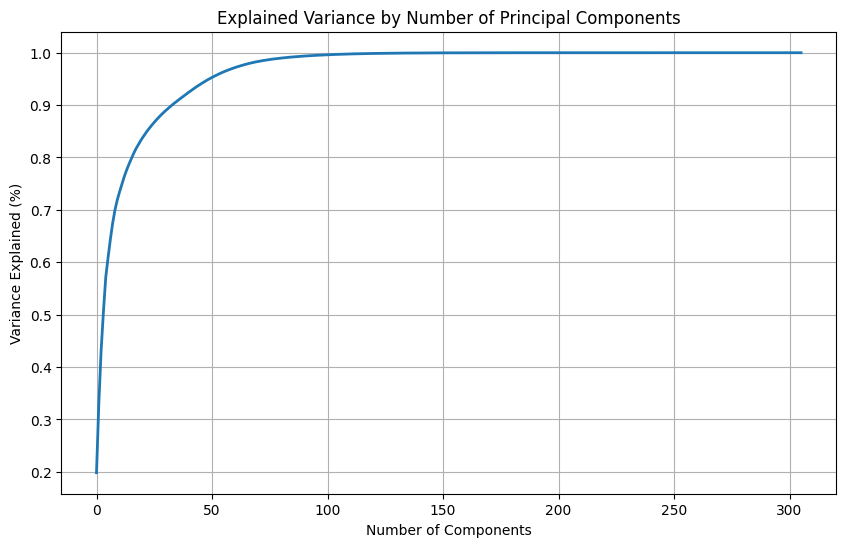

In [ ]:
scalar = StandardScaler()

x_scaled = scalar.fit_transform(X)

pca = PCA()
x_pca = pca.fit(x_scaled)

# Plot explaining variance to decide number of components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained (%)') # for each component
plt.title('Explained Variance by Number of Principal Components')
plt.grid()
plt.show()

In [ ]:
# Determine the number of components which explain 99% of the variance in the data
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.99) + 1
print(f'Number of components explaining 99% of variance: {n_components}')

# # Create a new set of features(components) based on the components which explain 100% of the variance in the data
pca = PCA(n_components= n_components)
x_reduced = pca.fit_transform(x_scaled)

 # Create a dataframe of the features used to derive the principal components. The loading values indicate the contribution of each feature
loadings = pca.components_.T
feature_names = X.columns
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=feature_names)

# Sort the features by their loading values in descending order
loadings_df = loadings_df.sort_values(by= 'PC1', ascending=False)
loadings_df.head()


Number of components explaining 99% of variance: 82


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82
avg_Period,0.110349,-0.052465,0.001874,0.015330,0.040522,-0.027451,0.004613,-0.084025,0.006066,-0.013257,...,-0.051864,-0.022070,0.020316,-0.018829,0.030169,-0.016822,0.041659,0.076840,-0.024879,0.018754
avg_ionic_radius,0.107403,-0.033582,-0.059750,0.032893,-0.005486,-0.020947,-0.009552,-0.078273,0.026926,-0.033340,...,0.005153,-0.029336,0.005612,-0.030933,0.019635,0.025964,0.019719,0.032128,-0.032262,0.031366
min_Atomic_Radius,0.106993,0.058559,0.039334,0.050678,-0.000295,0.004655,-0.033211,-0.051773,0.014971,-0.002720,...,0.021296,-0.006751,-0.015980,-0.026952,0.010547,-0.005093,-0.009652,-0.023203,0.001207,-0.018803
Average Atomic Radius,0.106857,-0.067370,-0.035543,0.039211,-0.022681,-0.000811,-0.001877,-0.045103,0.010067,0.001081,...,-0.018260,-0.029526,-0.006406,-0.016716,0.007095,0.022333,0.045149,0.049669,-0.009536,0.019506
avg_Covalent_Radius,0.106404,-0.038478,-0.028583,0.037050,0.007315,-0.044390,0.001556,-0.090109,0.025099,-0.038049,...,-0.033063,-0.032152,0.046164,-0.022762,-0.028374,-0.005464,0.074310,0.037448,0.001911,0.003888


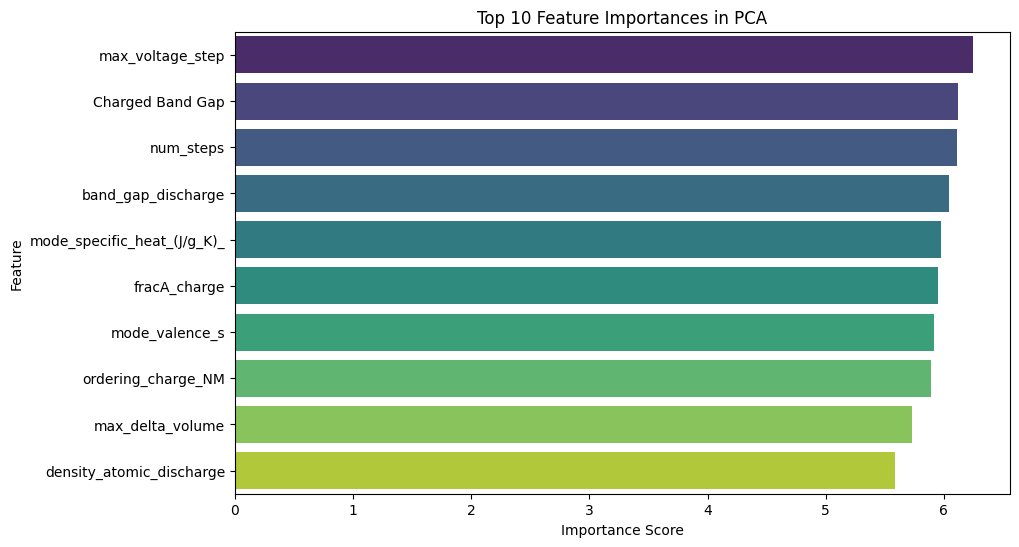

In [ ]:
# Calculate the overall importance of each feature by summing the absolute values of the loadings
importance_scores = np.sum(np.abs(loadings), axis=1)

# Create a DataFrame for the importance scores
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)  # Top 10 features

# Plotting the top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette = 'viridis')
plt.title('Top 10 Feature Importances in PCA')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

 # DNN MODEL

In [ ]:

# Split the data into the training set and the testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# # Define the DNN model
model = Sequential([
    Dense(168, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    # Dense(15, activation='relu'),
    # Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# # Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)




# # Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32,shuffle= True,validation_split=0.2)


NameError: name 'Sequential' is not defined

27/27 [==============================] - 0s 1ms/step
Mean Absolute Error (MAE): 0.15894308772738322
R² score for testing set: 0.9486


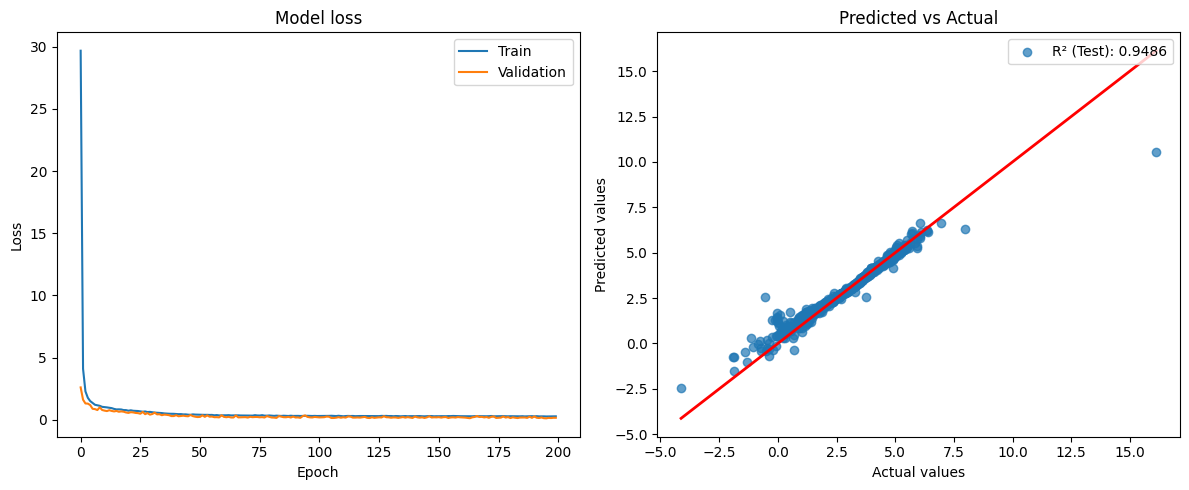

In [ ]:
# Predict on the testing set
y_test_pred = model.predict(X_test)

# Calculate R² score
r2_test = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
print(f'Mean Absolute Error (MAE): {mae}')

print(f'R² score for testing set: {r2_test:.4f}')

# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot predicted vs actual values
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.title('Predicted vs Actual')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.legend([f'R² (Test): {r2_test:.4f}'], loc='upper right')

plt.tight_layout()
plt.show()

###RANDOM FOREST###

In [ ]:
# Train the Random Forest model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 0.21452598889701396
R-squared (R²): 0.8906762531430474


In [ ]:
comparison_df = pd.DataFrame({'Actual Voltage': y_test, 'Predicted Voltage': y_pred})
comparison_df.head()

,Actual Voltage,Predicted Voltage
3188,1.502793,1.889112
764,3.961299,3.963137
3264,4.873283,4.346870
1967,3.349825,3.645128
2185,4.733139,4.335896


In [ ]:
# Use the TreeExplainer for Random Forests
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Create a mapping of original feature names to new feature names
feature_name_mapping = {
    'energy_grav': 'Gravimetric Energy',
    'capacity_grav': 'Gravimetric Capacity',
    'capacity_vol': 'Volumetric Capacity',
    'avg_Mendeleev_Number': 'Average Mendeleev Number',
    'energy_vol': 'Volumetric Energy',
    'range_metallic_valence': 'Range of Metallic Valence',
    'working_ion_Zn': 'Working Ion',
    'band_gap_charge': 'Charged Band Gap',
    'avg_Atomic_Radius': 'Average Atomic Radius',
    'stability_discharge': 'Discharge Stability'
}
X_test_renamed = X_test.rename(columns=feature_name_mapping)

# For regression tasks, shap_values is a single array
shap_values = shap_values

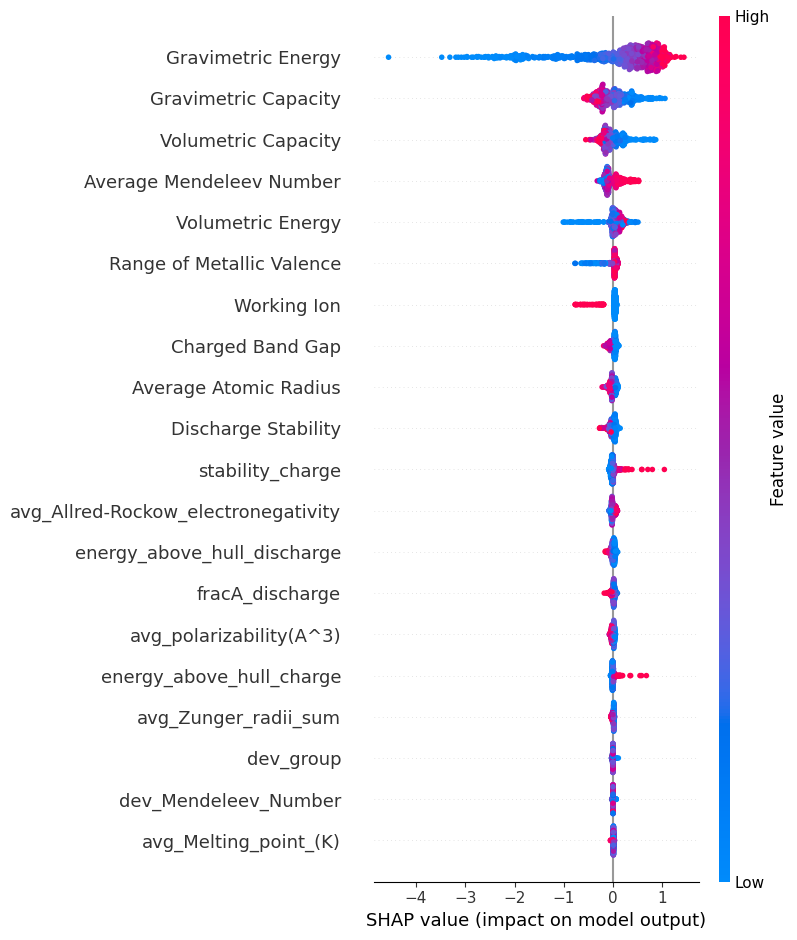

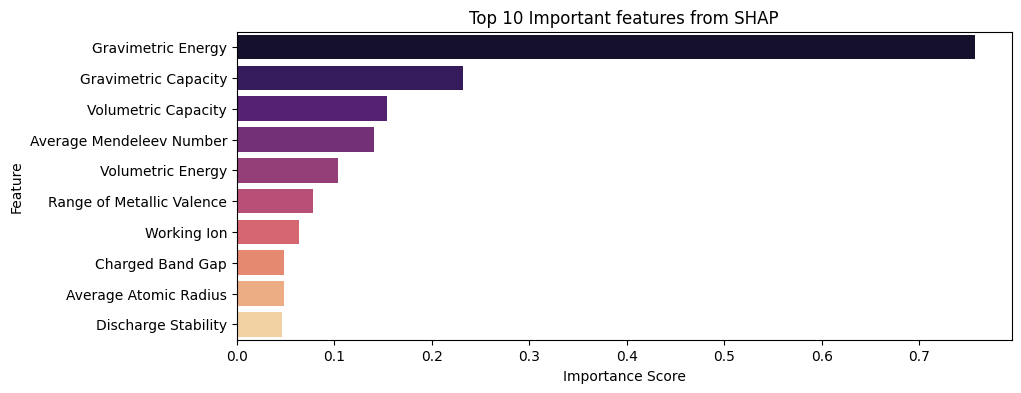

In [ ]:
# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test_renamed)

# Calculate the mean absolute SHAP values for each feature
feature_importance = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)  # Top 10 features

# Plotting the top 10 features with SHAP values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="magma")
plt.title('Top 10 Important features from SHAP')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

